In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

## Preprocessing

In [2]:
df = pd.read_csv("data/vehicles.csv")

# remove unnecessary columns
columns_to_drop = [
    'url', 'region_url', 'vin', 'image_url', 'description',
    'county', 'size', 'lat', 'long', 'title_status'
]
cols_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop, errors='ignore')

# change datetime and create car_age
if 'posting_date' in df.columns:
    df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce', utc=True)
    df['car_age'] = df['posting_date'].dt.year - df['year']

# remove outliers
original_size = len(df)
df = df[(df['price'] >= 1000) & (df['price'] <= 80000)]
if 'car_age' in df.columns:
    df = df[df['car_age'].between(0, 30, inclusive='both')]
if 'odometer' in df.columns:
    df = df[df['odometer'] <= 1000000]
removed = original_size - len(df)


# missing values
critical_cols = ['price', 'year', 'manufacturer', 'model', 'odometer']
critical_cols = [col for col in critical_cols if col in df.columns]
original_size = len(df)
df = df.dropna(subset=critical_cols)
dropped = original_size - len(df)
print(f"Dropped {dropped} rows")

fill_unknown_cols = ['condition', 'cylinders', 'fuel', 'drive',
                    'transmission', 'paint_color', 'type', 'region', 'state']
for col in fill_unknown_cols:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            df[col] = df[col].fillna('unknown')

df = df.reset_index(drop=True)
print(df.shape)

Dropped 14739 rows
(348676, 18)


In [3]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,VIN,drive,type,paint_color,state,posting_date,car_age
0,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,other,3GTP1VEC4EG551563,unknown,pickup,white,al,2021-05-04 17:31:18+00:00,7.0
1,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,other,1GCSCSE06AZ123805,unknown,pickup,blue,al,2021-05-04 17:31:08+00:00,11.0
2,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,other,3GCPWCED5LG130317,unknown,pickup,red,al,2021-05-04 17:31:25+00:00,1.0
3,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,other,5TFRM5F17HX120972,unknown,pickup,red,al,2021-05-04 15:41:31+00:00,4.0
4,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,automatic,NaN,rwd,truck,black,al,2021-05-03 19:02:03+00:00,8.0


## Feature Engineering setup

In [4]:
X = df.drop('price', axis=1)
y = df['price']

# feature type
high_missing_cols = ['cylinders', 'condition']
numeric_cols = ['year', 'car_age', 'odometer']
embedding_cols = ['model', 'region']  # High cardinality
onehot_cols = ['manufacturer', 'fuel', 'transmission', 'drive',
               'type', 'paint_color', 'state']  # Low-medium cardinality

cols_to_drop = [col for col in high_missing_cols if col in X.columns]
X_clean = X.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} high missing columns: {cols_to_drop}")

categorical_cols = embedding_cols + onehot_cols
for col in categorical_cols:
    if col in X_clean.columns:
        missing_count = X_clean[col].isna().sum()
        if missing_count > 0:
            X_clean[col] = X_clean[col].fillna('unknown')

Dropped 2 high missing columns: ['cylinders', 'condition']


### XGBoost feature engineering

In [5]:
X_xgb = X_clean.copy()

# remove non feature columns
non_feature_cols = ['id', 'posting_date', 'VIN']
for col in non_feature_cols:
    if col in X_xgb.columns:
        X_xgb = X_xgb.drop(columns=[col])

# label encode all categorical features
encoders_xgb = {}
for col in categorical_cols:
    if col in X_xgb.columns:
        le = LabelEncoder()
        X_xgb[f'{col}_encoded'] = le.fit_transform(X_xgb[col].astype(str))
        encoders_xgb[f'{col}_xgb'] = le
        X_xgb = X_xgb.drop(columns=[col])

# numeric columns
numeric_columns = X_xgb.select_dtypes(include=[np.number]).columns
X_xgb = X_xgb[numeric_columns]

### Neural Network feature engineering

In [6]:
scaler = StandardScaler()
encoders_nn = {}

# numeric features (scaled)
X_numeric = X_clean[numeric_cols].copy()
X_numeric_scaled = scaler.fit_transform(X_numeric)
X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=numeric_cols)

# embedding features (label encoded)
X_embedding = {}
embedding_vocab_sizes = {}
for col in embedding_cols:
    if col in X_clean.columns:
        le = LabelEncoder()
        encoded = le.fit_transform(X_clean[col].astype(str))
        X_embedding[col] = encoded
        embedding_vocab_sizes[col] = len(le.classes_)
        encoders_nn[f'{col}_nn'] = le

# one-hot features
onehot_cols_available = [col for col in onehot_cols if col in X_clean.columns]
if onehot_cols_available:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_onehot = ohe.fit_transform(X_clean[onehot_cols_available])
    X_onehot = pd.DataFrame(X_onehot, columns=ohe.get_feature_names_out(onehot_cols_available))
    encoders_nn['onehot_nn'] = ohe
else:
    X_onehot = pd.DataFrame()

nn_features = {
    'numeric': X_numeric_scaled,
    'embedding': X_embedding,
    'onehot': X_onehot
}

## Model Training

### XGBoost model training

In [7]:
# Split data
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42
)

print(f"XGBoost data split - train: {X_train_xgb.shape[0]}, test: {X_test_xgb.shape[0]}")

# rain 
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 6,
    'tree_method': 'hist',
    'device': 'cpu',
    'random_state': 42
}

xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train_xgb, y_train_xgb)

# predict
y_pred_xgb = xgb_model.predict(X_test_xgb)

xgb_mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
xgb_r2 = r2_score(y_test_xgb, y_pred_xgb)

print(f"\nXGBoost Model Performance:")
print(f"MAE: ${xgb_mae:,.2f}")
print(f"RMSE: ${xgb_rmse:,.2f}")
print(f"R²: {xgb_r2:.4f}")

# Save XGBoost metrics
xgb_metrics = {
    'mae': xgb_mae,
    'rmse': xgb_rmse,
    'r2': xgb_r2,
    'predictions': y_pred_xgb,
    'y_test': y_test_xgb
}

XGBoost data split - train: 278940, test: 69736

XGBoost Model Performance:
MAE: $3,103.17
RMSE: $4,784.29
R²: 0.8808


### Neural Network data preparation

In [8]:
indices = range(len(y))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42
)

# split numeric features
X_num_train = X_numeric_scaled.iloc[train_idx].values
X_num_test = X_numeric_scaled.iloc[test_idx].values

# split embedding features
X_embed_train, X_embed_test = {}, {}
for col, values in X_embedding.items():
    X_embed_train[col] = values[train_idx].reshape(-1, 1)
    X_embed_test[col] = values[test_idx].reshape(-1, 1)

# split one-hot features
X_onehot_train = X_onehot.iloc[train_idx].values
X_onehot_test = X_onehot.iloc[test_idx].values

# split target
y_train_nn = y.iloc[train_idx].values
y_test_nn = y.iloc[test_idx].values

### Neural Network model building

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

# build multi-input neural network
embedding_dims = {'model': 16, 'region': 8}

# numeric input
numeric_input = Input(shape=(X_numeric_scaled.shape[1],), name='numeric')
numeric_dense = Dense(64, activation='relu')(numeric_input)
numeric_dense = BatchNormalization()(numeric_dense)

# embedding inputs
embedding_inputs = []
embedding_outputs = []

for col, vocab_size in embedding_vocab_sizes.items():
    embed_input = Input(shape=(1,), name=f'{col}_input')
    embed_dim = embedding_dims.get(col, min(16, vocab_size // 4))
    embed_layer = Embedding(vocab_size, embed_dim, name=f'{col}_embed')(embed_input)
    embed_flat = Flatten()(embed_layer)
    
    embedding_inputs.append(embed_input)
    embedding_outputs.append(embed_flat)
    print(f"Embedding {col}: vocab_size={vocab_size}, embed_dim={embed_dim}")

# One-hot input
onehot_input = Input(shape=(X_onehot.shape[1],), name='onehot')
onehot_dense = Dense(64, activation='relu')(onehot_input)
onehot_dense = BatchNormalization()(onehot_dense)

all_inputs = [numeric_input] + embedding_inputs + [onehot_input]
all_features = [numeric_dense] + embedding_outputs + [onehot_dense]

# main network
concat = Concatenate()(all_features)
x = Dense(256, activation='relu')(concat)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x1 = Dense(128, activation='relu')(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

x2 = Dense(128, activation='relu')(x1)
x2 = BatchNormalization()(x2)

x_skip = Dense(128)(x)
x_res = Add()([x2, x_skip])
x_res = Dropout(0.3)(x_res)

x_final = Dense(64, activation='relu')(x_res)
x_final = BatchNormalization()(x_final)
x_final = Dropout(0.2)(x_final)

output = Dense(1, name='price')(x_final)

nn_model = Model(inputs=all_inputs, outputs=output)
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

Embedding model: vocab_size=20158, embed_dim=16
Embedding region: vocab_size=404, embed_dim=8


### Neural Network training

In [11]:
train_inputs = [X_num_train] + list(X_embed_train.values()) + [X_onehot_train]

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# train model
print("Training Neural Network model...")
history = nn_model.fit(
    train_inputs,
    y_train_nn,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Training Neural Network model...
Epoch 1/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 557020608.0000 - mae: 19226.2578 - val_loss: 538089344.0000 - val_mae: 19008.2070 - learning_rate: 0.0010
Epoch 2/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 516393248.0000 - mae: 18636.8965 - val_loss: 470377152.0000 - val_mae: 17982.6836 - learning_rate: 0.0010
Epoch 3/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 444263776.0000 - mae: 17464.9805 - val_loss: 384369536.0000 - val_mae: 16427.2754 - learning_rate: 0.0010
Epoch 4/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 357079936.0000 - mae: 15871.3701 - val_loss: 291945632.0000 - val_mae: 14626.9932 - learning_rate: 0.0010
Epoch 5/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 265948496.0000 - mae: 13929.2148 - val_loss: 197509488.0000 - val_mae: 12300.7715 - learning_rate: 0.0010
Epoch 6/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 180889952.0000 - mae: 11699.9775 - val_loss: 125148576.0000 - val

### Neural Network evaluation

In [12]:
test_inputs = [X_num_test] + list(X_embed_test.values()) + [X_onehot_test]

y_pred_nn = nn_model.predict(test_inputs).flatten()

nn_mae = mean_absolute_error(y_test_nn, y_pred_nn)
nn_rmse = np.sqrt(mean_squared_error(y_test_nn, y_pred_nn))
nn_r2 = r2_score(y_test_nn, y_pred_nn)

print(f"\nNeural Network Model Performance:")
print(f"MAE: ${nn_mae:,.2f}")
print(f"RMSE: ${nn_rmse:,.2f}")
print(f"R²: {nn_r2:.4f}")

# Save NN metrics
nn_metrics = {
    'mae': nn_mae,
    'rmse': nn_rmse,
    'r2': nn_r2,
    'predictions': y_pred_nn,
    'y_test': y_test_nn
}

2180/2180 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step

Neural Network Model Performance:
MAE: $2,181.91
RMSE: $3,731.32
R²: 0.9275


## Model Comparison

In [13]:
comparison_data = {
    'Model': ['XGBoost', 'Neural Network'],
    'MAE ($)': [f"{xgb_metrics['mae']:,.2f}", f"{nn_metrics['mae']:,.2f}"],
    'RMSE ($)': [f"{xgb_metrics['rmse']:,.2f}", f"{nn_metrics['rmse']:,.2f}"],
    'R²': [f"{xgb_metrics['r2']:.4f}", f"{nn_metrics['r2']:.4f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

if nn_metrics['r2'] > xgb_metrics['r2']:
    best_model = 'Neural Network'
    improvement = ((nn_metrics['r2'] - xgb_metrics['r2']) / xgb_metrics['r2']) * 100
else:
    best_model = 'XGBoost'
    improvement = ((xgb_metrics['r2'] - nn_metrics['r2']) / nn_metrics['r2']) * 100

print(f"\nBest Model: {best_model}")
print(f"R² Improvement: {improvement:.2f}%")

Model Performance Comparison:
         Model  MAE ($) RMSE ($)     R²
       XGBoost 3,103.17 4,784.29 0.8808
Neural Network 2,181.91 3,731.32 0.9275

Best Model: Neural Network
R² Improvement: 5.30%


## Visualization

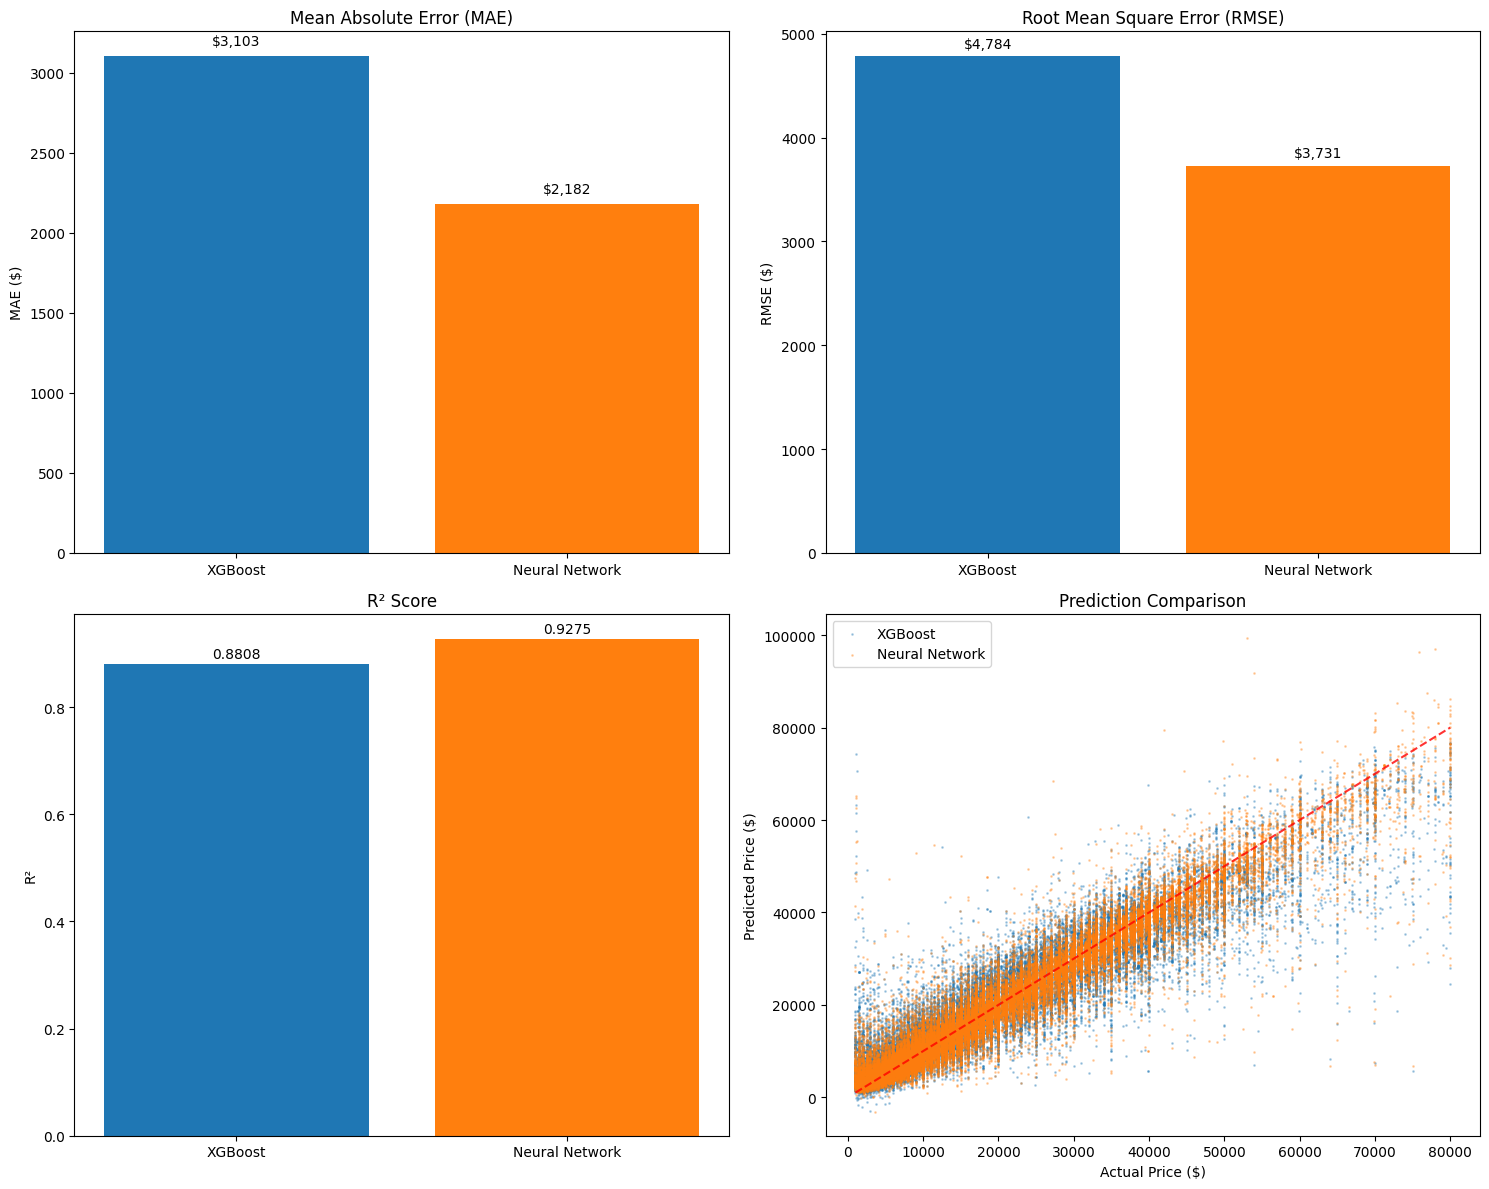

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Metrics comparison
models = ['XGBoost', 'Neural Network']
mae_values = [xgb_metrics['mae'], nn_metrics['mae']]
rmse_values = [xgb_metrics['rmse'], nn_metrics['rmse']]
r2_values = [xgb_metrics['r2'], nn_metrics['r2']]

# MAE comparison
axes[0, 0].bar(models, mae_values, color=['#1f77b4', '#ff7f0e'])
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE ($)')
for i, v in enumerate(mae_values):
    axes[0, 0].text(i, v + 50, f'${v:,.0f}', ha='center', va='bottom')

# RMSE comparison
axes[0, 1].bar(models, rmse_values, color=['#1f77b4', '#ff7f0e'])
axes[0, 1].set_title('Root Mean Square Error (RMSE)')
axes[0, 1].set_ylabel('RMSE ($)')
for i, v in enumerate(rmse_values):
    axes[0, 1].text(i, v + 50, f'${v:,.0f}', ha='center', va='bottom')

# R² comparison
axes[1, 0].bar(models, r2_values, color=['#1f77b4', '#ff7f0e'])
axes[1, 0].set_title('R² Score')
axes[1, 0].set_ylabel('R²')
for i, v in enumerate(r2_values):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

# Prediction scatter plot
axes[1, 1].scatter(y_test_xgb, y_pred_xgb, alpha=0.3, label='XGBoost', s=1)
axes[1, 1].scatter(y_test_nn, y_pred_nn, alpha=0.3, label='Neural Network', s=1)
min_val = min(y_test_xgb.min(), y_test_nn.min())
max_val = max(y_test_xgb.max(), y_test_nn.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].set_title('Prediction Comparison')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance (XGBoost)

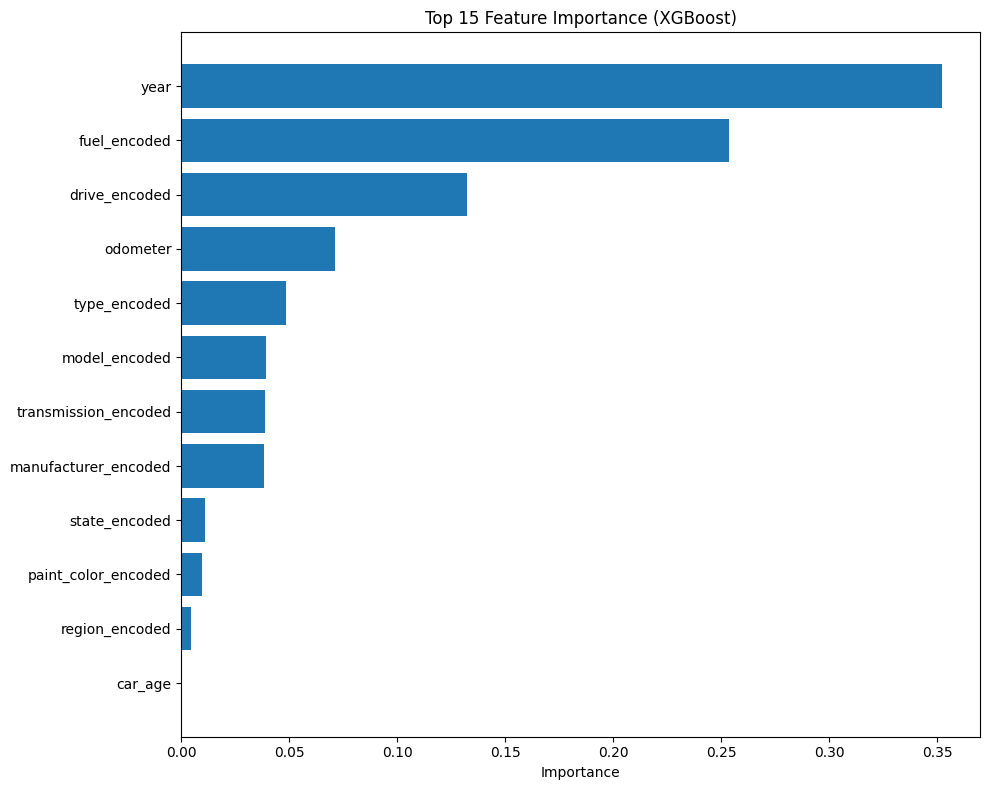

Top 15 Most Important Features:
             feature  importance
                year    0.352281
        fuel_encoded    0.253878
       drive_encoded    0.132489
            odometer    0.071045
        type_encoded    0.048494
       model_encoded    0.039116
transmission_encoded    0.038983
manufacturer_encoded    0.038515
       state_encoded    0.010915
 paint_color_encoded    0.009815
      region_encoded    0.004469
             car_age    0.000000


In [15]:
importance_df = pd.DataFrame({
    'feature': X_xgb.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 15 Most Important Features:")
print(importance_df.to_string(index=False))